Classification Model

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [ ]:
df_pluviometricos = pd.read_csv("../dados/dados_pluviometricos_geo_anos.csv")

In [ ]:
df_curva_niveis = pd.read_csv("../dados/dados_curva_niveis.csv")

In [ ]:
df_curva_niveis = df_curva_niveis[["score", "hex", "geometry", "Elevation"]]

In [ ]:
df_curva_niveis = df_curva_niveis.groupby(["hex", "geometry"], as_index=False)["Elevation", "score"].mean()

Preparar dados de Lagos, Rios e Cavas

In [ ]:
df_hidro = pd.read_csv("../dados/lagos_rios.csv")

Preparar Feature do Solo

In [ ]:
df_feature_solo = pd.read_csv("../dados/feature_solo.csv")

Preparar o dataset de Feature de Uso de Solos

In [ ]:
df_feature_uso_solo = pd.read_csv("../dados/feature_uso_solos.csv")

Preparar o dataset de alagamentos (o target)

In [ ]:
df_alagamentos = pd.read_csv("../dados/alagamentos.csv")

In [ ]:
df_alagamentos["flooded"] = df_alagamentos["NATUREZA"]

In [ ]:
df_alagamentos["date"] = df_alagamentos["DATA"]
df_alagamentos = df_alagamentos[["flooded", "date", "hex", "NOME", "geometry"]]

In [ ]:

df_alagamentos.date = df_alagamentos.date.astype('datetime64[ns]')

In [ ]:
df_alagamentos['date'] = df_alagamentos['date'].dt.strftime('%Y-%m-%d')

In [ ]:
print(len(df_alagamentos))
print(len(df_alagamentos[df_alagamentos["flooded"] == "Alagamento"]))

Preparar a elevação

In [ ]:
df_merged = pd.merge(df_alagamentos, df_curva_niveis, on="geometry", how="left")

In [ ]:
df_merged["elevation"] = df_merged["Elevation"]
df_merged["hex"] = df_merged["hex_x"]
df_merged["score_elevation"] = df_merged["score"]
df_merged = df_merged[["flooded", "date", "hex", "geometry", "score_elevation", "elevation"]]

In [ ]:
df_merged.drop_duplicates(inplace=True)

In [ ]:
print(len(df_merged))
print(len(df_merged[df_merged["flooded"] == "Alagamento"]))

In [ ]:
df_merged = pd.merge(df_merged, df_pluviometricos, on=["geometry", "date"], how="outer")

In [ ]:

df_merged["value_precipitation"] = df_merged["valorMedido"]
df_merged["value_precipitation_3_days"] = df_merged["value_last_3_days"]
df_merged["value_precipitation_7_days"] = df_merged["value_last_7_days"]
df_merged["hex"] = df_merged["hex_x"]
df_merged = df_merged[["flooded", "date", "hex", "geometry", "score_elevation", "elevation", "value_precipitation", "value_precipitation_3_days", "value_precipitation_7_days"]]

In [ ]:
df_merged = pd.merge(df_merged, df_curva_niveis[['geometry', 'score', 'Elevation']], on='geometry', how='left')

In [ ]:
print(len(df_merged))
print(len(df_merged[df_merged["flooded"] == "Alagamento"]))
print(len(df_merged[df_merged["flooded"].isna()]))
print(len(df_merged[df_merged["value_precipitation"].isna()]))

In [ ]:
df_merged['score_elevation'].fillna(df_merged['score'], inplace=True)
df_merged['elevation'].fillna(df_merged['Elevation'], inplace=True)
df_merged['flooded'].fillna("Nenhum", inplace=True)

In [ ]:
df_merged.drop(columns='score', inplace=True)
df_merged.drop(columns='Elevation', inplace=True)

In [ ]:
print(len(df_merged))
print(len(df_merged[df_merged["flooded"] == "Alagamento"]))
print(len(df_merged[df_merged["flooded"].isna()]))
print(len(df_merged[df_merged["value_precipitation"].isna()]))

Pegar apenas as linhas que possuem valores válidos de precipitação 

In [ ]:
df_merged = df_merged[df_merged['value_precipitation'].notna()]

In [ ]:
print(len(df_merged))
print(len(df_merged[df_merged["flooded"] == "Alagamento"]))
print(len(df_merged[df_merged["flooded"].isna()]))
print(len(df_merged[df_merged["value_precipitation"].isna()]))

In [ ]:
df_merged = pd.merge(df_merged, df_hidro[['hex', 'score_hidro', 'neighbors_hidro']], on='hex', how='left')

In [ ]:
df_merged["score_hidro"].fillna(0.0, inplace=True)
df_merged["neighbors_hidro"].fillna(0.0, inplace=True)

In [ ]:
df_merged = pd.merge(df_merged, df_feature_solo, on=['hex', "geometry"], how='left')

In [ ]:
df_merged = pd.merge(df_merged, df_feature_uso_solo, on=["hex", "geometry"], how="left")

In [ ]:
df_merged.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"], inplace=True)

In [ ]:
df_merged = df_merged[df_merged['value_precipitation'].notna()]
print(len(df_merged))
print(len(df_merged[df_merged["flooded"] == "Alagamento"]))
print(len(df_merged[df_merged["flooded"].isna()]))
print(len(df_merged[df_merged["value_precipitation"].isna()]))

In [ ]:
df_merged.drop_duplicates(inplace=True)
print(len(df_merged))
print(len(df_merged[df_merged["flooded"] == "Alagamento"]))
print(len(df_merged[df_merged["flooded"].isna()]))
print(len(df_merged[df_merged["value_precipitation"].isna()]))

In [ ]:
df_merged.head()

In [ ]:
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day

In [ ]:
# df_merged.to_csv("../dados/dados_complestos.csv")

In [3]:
df_merged = pd.read_csv("../dados/dados_complestos.csv")

/var/folders/ld/8dhf4gy93xbd1ybmf6nljm38dn1p1r/T/ipykernel_18315/888267823.py:1: DtypeWarning: Columns (3,12,13,14,15,16,18,19,20,21,22,23,24,25,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv("../dados/dados_complestos.csv")


Rodar modelo de classificação

In [4]:
features_elevation = ['elevation', 'score_elevation']
features_precipitation = ['value_precipitation', 'value_precipitation_3_days', 'value_precipitation_7_days']
features_hidro = ['score_hidro', 'neighbors_hidro']
date = ["year", "month", "day"]

In [5]:
# features = df_merged[features_precipitation+date]
# features = df_merged[features_elevation+date]
# features = df_merged[features_hidro+date]
features = df_merged[features_precipitation+features_elevation+date]
# features = df_merged[features_elevation+features_precipitation+features_hidro+date]
target = df_merged[['flooded']]

In [6]:
train_features, test_features, train_labels, test_labels = train_test_split(features, target, test_size=0.2)

In [7]:
rf = RandomForestClassifier()
rf.fit(train_features, train_labels)

/var/folders/ld/8dhf4gy93xbd1ybmf6nljm38dn1p1r/T/ipykernel_18315/2852299628.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_features, train_labels)


RandomForestClassifier()

In [8]:
predictions = rf.predict(test_features)

In [9]:
print("Accuracy: " + str(accuracy_score(test_labels, predictions)))
print("Recall for nothing: " + str(recall_score(test_labels, predictions, average="binary", pos_label="Nenhum")))
print("Recall for flooded: " + str(recall_score(test_labels, predictions, average="binary", pos_label="Alagamento")))
print(confusion_matrix(test_labels, predictions))

Accuracy: 0.9996981452703836
Recall for nothing: 1.0
Recall for flooded: 0.325
[[   13    27]
 [    0 89407]]


In [10]:
from sklearn.model_selection import cross_validate

scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

result_cross_validate = cross_validate(RandomForestClassifier(random_state=42), train_features, train_labels, cv=10, scoring=scoring)


/Users/cnoboa/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cnoboa/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cnoboa/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cnoboa/opt/anaconda3/envs/geo_env/lib/pyth

In [ ]:
result_cross_validate

In [11]:
print("fit_time_average: " + str(result_cross_validate["fit_time"].mean()))
print("score_time_average: " + str(result_cross_validate["score_time"].mean()))
print("accuracy_average: " + str(result_cross_validate["test_accuracy"].mean()))
print("precision_average: " + str(result_cross_validate["test_precision_macro"].mean()))
print("recall_average: " + str(result_cross_validate["test_recall_macro"].mean()))
print("f1_average: " + str(result_cross_validate["test_f1_macro"].mean()))

fit_time_average: 35.73533661365509
score_time_average: 1.4907492637634276
accuracy_average: 0.999740068960274
precision_average: 0.9898727986294465
recall_average: 0.745748837644544
f1_average: 0.8240960004912428


In [ ]:
print("Len: " + str(len(predictions)))
alagamentos = []
nenhum = []
for f in predictions:
    if f == "Nenhum":
        nenhum.append(f)
    if f == "Alagamento":
        alagamentos.append(f)

print("Len alagamentos: " + str(len(alagamentos)))
print("Len nenhum: " + str(len(nenhum)))

Verificar a porcentagem de flooded

In [ ]:

total_alagamentos = len(df_merged[df_merged['flooded'] == "Alagamento"])
total_nenhum = len(df_merged[df_merged['flooded'] == "Nenhum"])

print("Alagamentos: " + str(total_alagamentos))
print("Nenhum: " + str(total_nenhum))
print("Porcentagem: " + str(100*total_alagamentos/(total_alagamentos+total_nenhum)) + "%")

Comparação entre Features

In [15]:
precipitation = {
    "name": "precipitation",
    "tempo": 6.42,
    "fit_time_average": 38.83778891563416,
    "score_time_average": 1.3207797527313232,
    "accuracy_average": 0.9996701951021427,
    "precision_average": 0.9417331467356099,
    "recall_average": 0.7113867304439336,
    "f1_average": 0.7771401645082686,
}

elevation = {
    "name": "elevation",
    "tempo": 3.5,
    "fit_time_average": 17.123146200180052,
    "score_time_average": 1.325027585029602,
    "accuracy_average": 0.9997205035519299,
    "precision_average": 0.9827215610566521,
    "recall_average": 0.7106575703095958,
    "f1_average": 0.7860634203058349  
}

hydro = {
    "name": "hydro",
    "tempo": 2.21,
    "fit_time_average": 12.78098750114441,
    "score_time_average": 1.3389266014099122,
    "accuracy_average": 0.9995779616031598,
    "precision_average": 0.8997889663871487,
    "recall_average": 0.5763071895424836,
    "f1_average": 0.6246381378776635
}

all = {
    "name": "all_features",
    "tempo": 7.28,
    "fit_time_average": 43.50116457939148,
    "score_time_average": 1.310783290863037,
    "accuracy_average": 0.9997121190576751,
    "precision_average": 0.9881705144520222,
    "recall_average": 0.7142128899321256,
    "f1_average": 0.7905460967619067
}

precipitation_plus_elevation = {
    "name": "preci+eleva",
    "tempo": 6.13,
    "fit_time_average": 35.73533661365509,
    "score_time_average": 1.4907492637634276,
    "accuracy_average": 0.999740068960274,
    "precision_average": 0.9898727986294465,
    "recall_average": 0.745748837644544,
    "f1_average": 0.8240960004912428
}

list_features = [precipitation, elevation, hydro, all_features, precipitation_plus_elevation]

only_f_score = {}
for feature in list_features:
    only_f_score[feature["name"]] = feature["f1_average"]

only_f_score

{'precipitation': 0.7771401645082686,
 'elevation': 0.7860634203058349,
 'hydro': 0.6246381378776635,
 'all_features': 0.7905460967619067,
 'precipitation_plus_elevation': 0.8240960004912428}

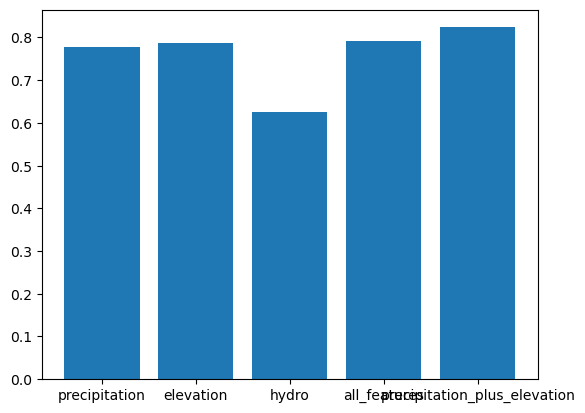

In [17]:
plt.bar(range(len(only_f_score)), list(only_f_score.values()), align='center')
plt.xticks(range(len(only_f_score)), list(only_f_score.keys()))
plt.show()